## Beer Consumption Prediction

#### This is a regression type of problem in which we will try to predict beer consumption among different age groups.

#### https://www.kaggle.com/datasets/dongeorge/beer-consumption-sao-paulo

#### Attribute information

#### Loading the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import LinearSVR
from fancyimpute import IterativeImputer
import regex as re

#### Loading the dataset

In [2]:
data = pd.read_csv("Consumo_cerveja.csv")

In [3]:
data.head()

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,"27,3","23,9","32,5",0,0.0,25.461
1,2015-01-02,"27,02","24,5","33,5",0,0.0,28.972
2,2015-01-03,"24,82","22,4","29,9",0,1.0,30.814
3,2015-01-04,"23,98","21,5","28,6","1,2",1.0,29.799
4,2015-01-05,"23,82",21,"28,3",0,0.0,28.900


In [4]:
data.rename(columns={"Data":"Date", "Temperatura Media (C)": "Temp_Medium",
                     "Temperatura Minima (C)":"Temp_Min","Temperatura Maxima (C)":"Temp_Max",
                     "Precipitacao (mm)":"Precipitaion", "Final de Semana":"Weekend", 
                     "Consumo de cerveja (litros)":"consumption"}, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          365 non-null    object 
 1   Temp_Medium   365 non-null    object 
 2   Temp_Min      365 non-null    object 
 3   Temp_Max      365 non-null    object 
 4   Precipitaion  365 non-null    object 
 5   Weekend       365 non-null    float64
 6   consumption   365 non-null    float64
dtypes: float64(2), object(5)
memory usage: 51.6+ KB


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Weekend,365.0,0.284932,0.452001,0.000,0.000,0.000,1.000,1.000
consumption,365.0,25.401367,4.399143,14.343,22.008,24.867,28.631,37.937


In [7]:
data.shape

(941, 7)

#### Converting the Object type columns 

In [8]:
data["Date"] = pd.to_datetime(data.Date)

#### Extract day, month and Year from the date column.

In [9]:
data["Day"] = data.Date.dt.day

In [10]:
data['Month'] = data.Date.dt.month

In [11]:
data['Year'] = data.Date.dt.year

In [12]:
data.drop(columns="Date", inplace=True)

In [13]:
data.dropna(inplace=True)

#### Change the datatype into int

In [14]:
data["Day"]= data["Day"].astype("int")
data["Month"]= data["Month"].astype("int")
data["Year"]= data["Year"].astype("int")
data['Weekend'] = data['Weekend'].astype("int")

In [15]:
data.isnull().sum()

Temp_Medium     0
Temp_Min        0
Temp_Max        0
Precipitaion    0
Weekend         0
consumption     0
Day             0
Month           0
Year            0
dtype: int64

In [16]:
data.columns

Index(['Temp_Medium', 'Temp_Min', 'Temp_Max', 'Precipitaion', 'Weekend',
       'consumption', 'Day', 'Month', 'Year'],
      dtype='object')

#### Formating the columns which contains special characters like commas

In [17]:
for i in data.columns:
    if data[i].dtypes == "object":
        data[i]=data[i].str.replace(",",".", regex=True)

In [18]:
data.head()

,Temp_Medium,Temp_Min,Temp_Max,Precipitaion,Weekend,consumption,Day,Month,Year
0,27.3,23.9,32.5,0,0,25.461,1,1,2015
1,27.02,24.5,33.5,0,0,28.972,2,1,2015
2,24.82,22.4,29.9,0,1,30.814,3,1,2015
3,23.98,21.5,28.6,1.2,1,29.799,4,1,2015
4,23.82,21,28.3,0,0,28.900,5,1,2015


In [19]:
data.Year.value_counts()

2015    365
Name: Year, dtype: int64

##### We may drop the year column as there is only one year is present.

In [20]:
data.drop(columns="Year", inplace=True)

#### Lets change the object data type into float.

In [21]:
for i in data.columns:
    if data[i].dtypes == "object":
        data[i] = data[i].astype("float")

In [22]:
data.head()

,Temp_Medium,Temp_Min,Temp_Max,Precipitaion,Weekend,consumption,Day,Month
0,27.30,23.9,32.5,0.0,0,25.461,1,1
1,27.02,24.5,33.5,0.0,0,28.972,2,1
2,24.82,22.4,29.9,0.0,1,30.814,3,1
3,23.98,21.5,28.6,1.2,1,29.799,4,1
4,23.82,21.0,28.3,0.0,0,28.900,5,1


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temp_Medium   365 non-null    float64
 1   Temp_Min      365 non-null    float64
 2   Temp_Max      365 non-null    float64
 3   Precipitaion  365 non-null    float64
 4   Weekend       365 non-null    int32  
 5   consumption   365 non-null    float64
 6   Day           365 non-null    int32  
 7   Month         365 non-null    int32  
dtypes: float64(5), int32(3)
memory usage: 21.4 KB


### Data visualisation

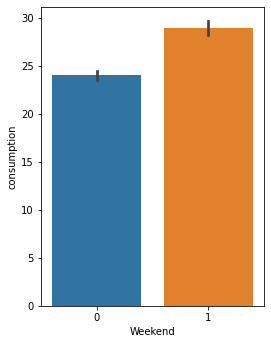

In [24]:
plt.figure(figsize=(4,5.5))
sns.barplot(data =data, x=data.Weekend, y=data.consumption);

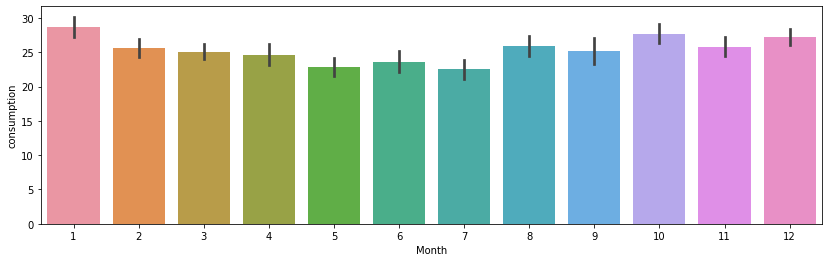

In [25]:
plt.figure(figsize=(14,4))
sns.barplot(data =data, x=data.Month, y=data.consumption);

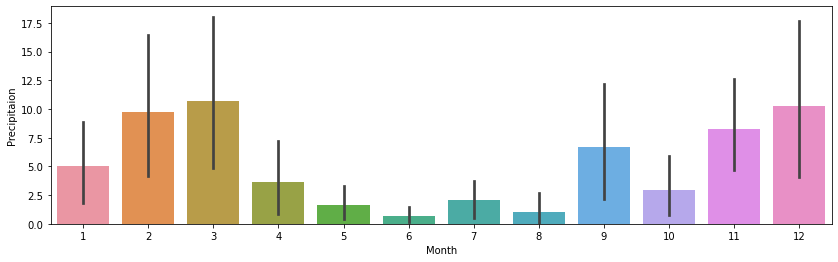

In [26]:
plt.figure(figsize=(14,4))
sns.barplot(data =data, x=data.Month, y=data.Precipitaion);

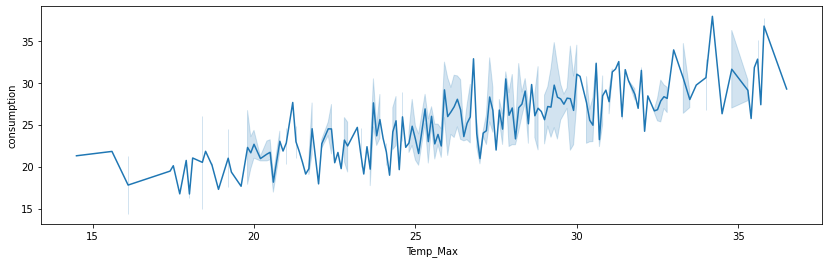

In [27]:
plt.figure(figsize=(14,4))
sns.lineplot(data = data, x=data.Temp_Max, y=data.consumption);

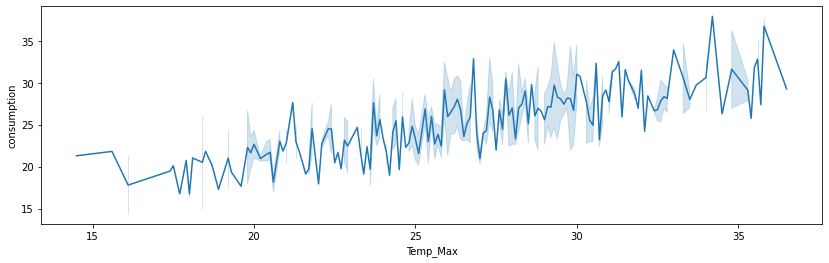

In [28]:
plt.figure(figsize=(14,4))
sns.lineplot(data = data, x=data.Temp_Max, y=data.consumption);

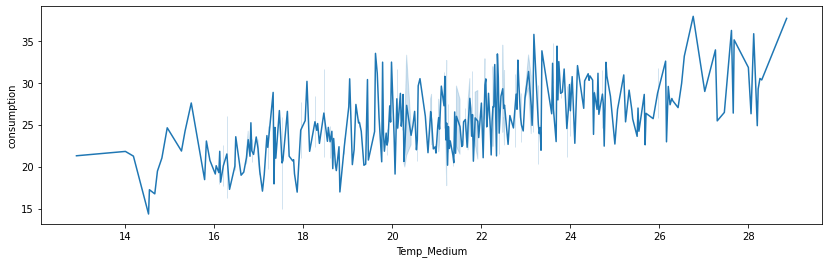

In [29]:
plt.figure(figsize=(14,4))
sns.lineplot(data = data, x=data.Temp_Medium, y=data.consumption);

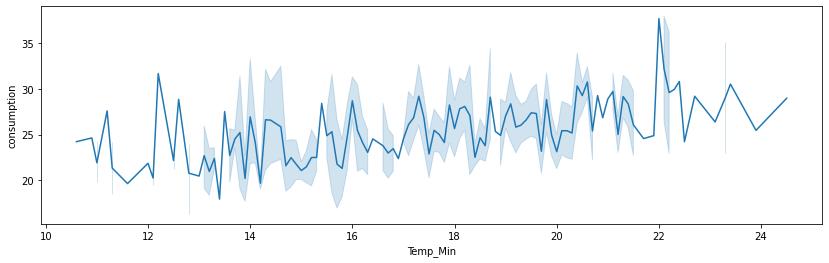

In [30]:
plt.figure(figsize=(14,4))
sns.lineplot(data = data, x=data.Temp_Min, y=data.consumption);

### Checking for outliers

#### Box plot

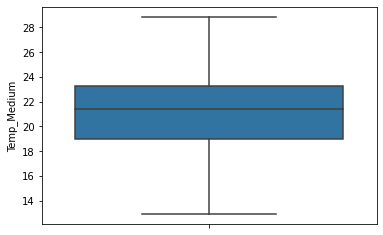

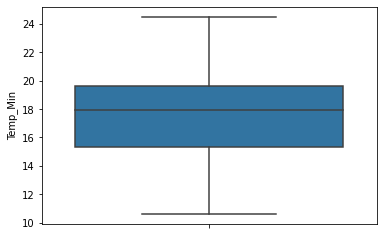

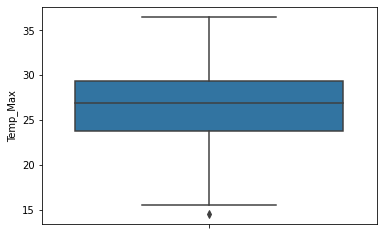

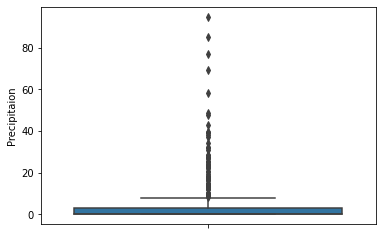

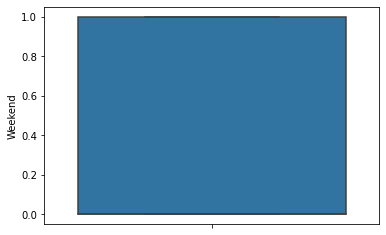

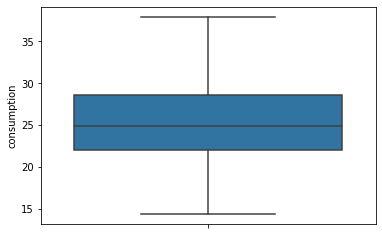

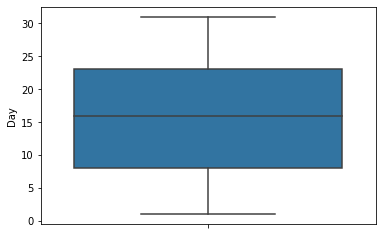

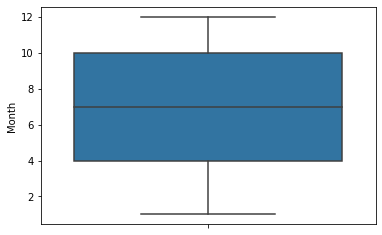

In [31]:
for i in data.columns:
    if data[i].dtype!= "object":
        sns.boxplot(y=data[i])
        plt.show()

#### Treating Outlier

In [32]:
def outlier_limit(col):
    Q3, Q1 = np.nanpercentile (col, [75,25])
    IQR = Q3 - Q1
    UL = Q3+1.5*IQR
    LL = Q1-1.5*Q1
    return UL, LL

In [33]:
for column in data.columns:
    if data[column].dtype != "object":
        UL, LL = outlier_limit(data[column])
        data[column] = np.where((data[column]>UL) | (data[column]<LL),np.nan,data[column])

In [34]:
data.dropna(inplace=True)

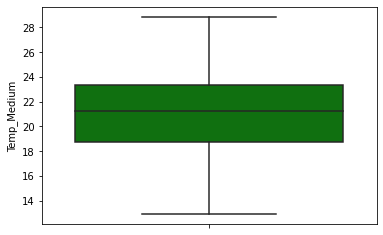

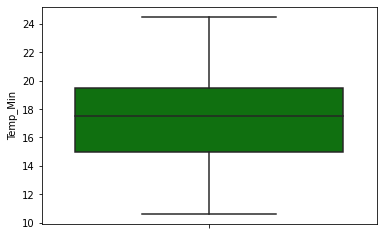

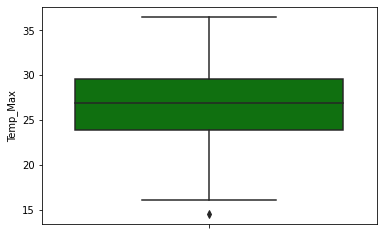

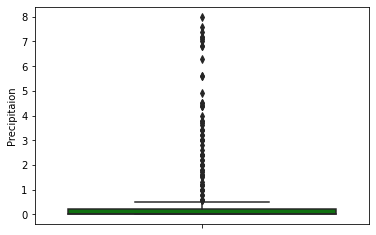

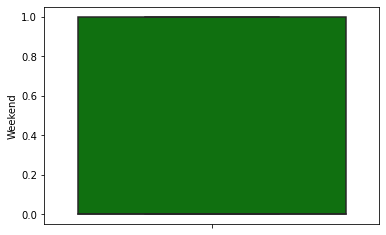

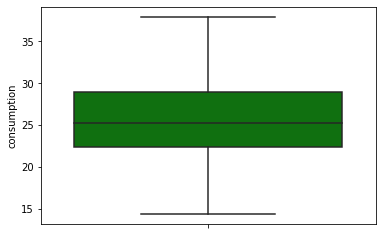

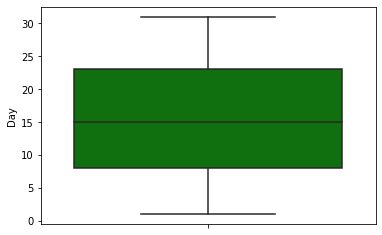

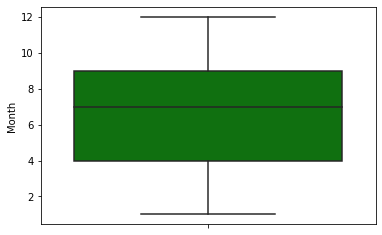

In [35]:
for i in data.columns:
    if data[i].dtype!= "object":
        sns.boxplot(y=data[i], color="Green")
        plt.show()

In [36]:
data.shape

(301, 8)

#### Histogram

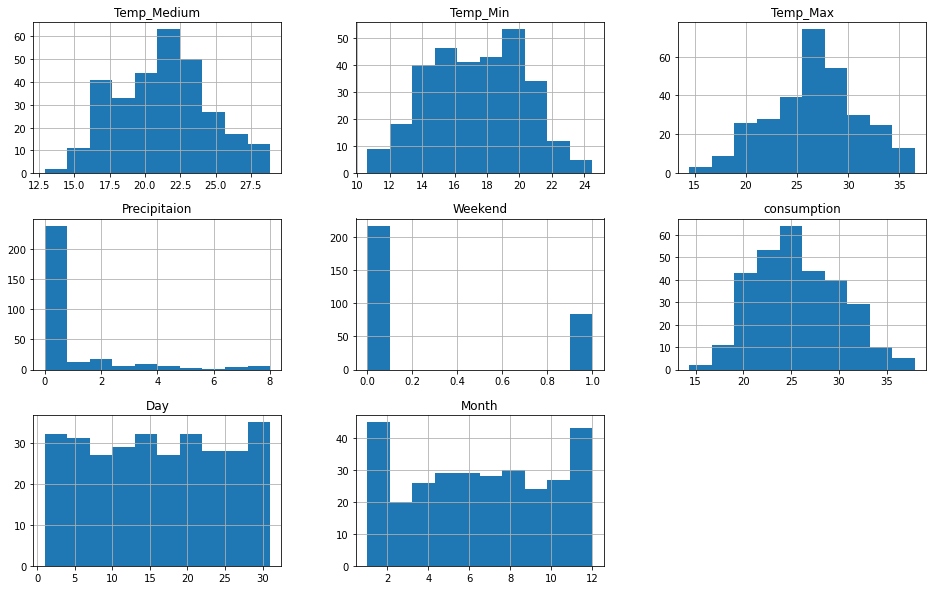

In [37]:
data.hist(figsize=(16,10));

#### Correlation matrix

<AxesSubplot:>

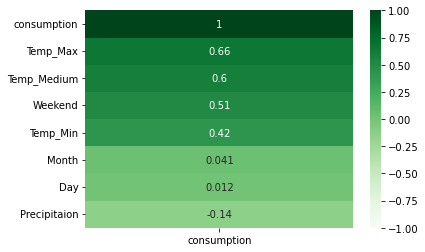

In [38]:
sns.heatmap(data.corr()[["consumption"]].sort_values(by="consumption", ascending=False), vmin=-1, vmax=1,annot=True, cmap="Greens")

#### Only some columns are having good correlation with consumption. We may select only those for model building.

In [39]:
data.columns

Index(['Temp_Medium', 'Temp_Min', 'Temp_Max', 'Precipitaion', 'Weekend',
       'consumption', 'Day', 'Month'],
      dtype='object')

In [40]:
data_model = data[['Temp_Medium', 'Temp_Min', 'Temp_Max', 'Weekend', 'consumption']]

In [41]:
x = data_model.iloc[:, :-1].values

In [42]:
y = data_model.iloc[:,-1].values

In [43]:
x.shape

(301, 4)

In [44]:
y.shape

(301,)

#### Scaling the data

In [45]:
sc = StandardScaler()

In [46]:
x = sc.fit_transform(x)

##### Splitting the data into training and testing

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#### Model building

In [48]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "LinearSVR":LinearSVR(),
    "DecisionTreeRegressor":DecisionTreeRegressor(),
    "GradientBoostingRegressor":GradientBoostingRegressor(),
    "AdaBoostRegressor":AdaBoostRegressor(),
    "RandomForestRegressor":RandomForestRegressor(random_state=0),
}

In [49]:
for name, model in models.items():
    model.fit(x_train, y_train)
    print("model trained with {}".format(name))
    training_score = model.score(x_train, y_train)*100
    testing_score = model.score(x_test, y_test)*100
    score = r2_score(y_test, model.predict(x_test))*100
    mae = mean_absolute_error(y_test, model.predict(x_test))
    mse = mean_squared_error(y_test, model.predict(x_test))
    rmse = np.sqrt(mse)
    print("r2score: ",score)
    print("training_score: ", training_score)
    print("testing_score: ", testing_score)
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse_test: ", rmse)
    print("*"*100)

model trained with LinearRegression
r2score:  74.44179408962833
training_score:  71.98994007686612
testing_score:  74.44179408962833
mae:  2.011035187340502
mse:  5.535280291105769
rmse_test:  2.3527176394769027
****************************************************************************************************
model trained with Ridge
r2score:  74.4802741316498
training_score:  71.98819023649773
testing_score:  74.4802741316498
mae:  2.011170244886744
mse:  5.5269464581697125
rmse_test:  2.3509458645765777
****************************************************************************************************
model trained with LinearSVR
r2score:  75.42208420501102
training_score:  70.40402456221382
testing_score:  75.42208420501102
mae:  1.9692747994512199
mse:  5.322973505008486
rmse_test:  2.3071570178486955
****************************************************************************************************
model trained with DecisionTreeRegressor
r2score:  57.935986154093456
training_

#### Lets proced with Random Forest Regressor.

### Hyper parameter tuning

In [50]:
rfr = RandomForestRegressor(random_state=0)

##### Setting the parameters

In [51]:
n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,

               'max_features': max_features,

               'max_depth': max_depth,

               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 15], 'max_features': ['auto', 'log2'], 'max_depth': [5, 10], 'bootstrap': [True, False]}


In [52]:
rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid, n_iter = 20, scoring='neg_mean_absolute_error', cv = 3, verbose=2, random_state=0, n_jobs=-1, return_train_score=True)

In [53]:
rfr_random.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10],
                                        'max_features': ['auto', 'log2'],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
                   random_state=0, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [54]:
rfr_random.best_params_

{'n_estimators': 12, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': True}

In [55]:
rfr_best = RandomForestRegressor(n_estimators=12, max_features="auto", max_depth=5, bootstrap=True)

In [56]:
rfr_best.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=12)

##### Metrics after Hyper parameter tuning

In [57]:
training_score = rfr_best.score(x_train, y_train)*100
testing_score = rfr_best.score(x_test, y_test)*100
score = r2_score(y_test, rfr_best.predict(x_test))*100
mae = mean_absolute_error(y_test, rfr_best.predict(x_test))
mse = mean_squared_error(y_test, rfr_best.predict(x_test))
rmse = np.sqrt(mse)
print("r2score: ",score)
print("training_score: ", training_score)
print("testing_score: ", testing_score)
print("mae: ", mae)
print("mse: ", mse)
print("rmse_test: ", rmse)

r2score:  73.70973182450727
training_score:  81.84501574490281
testing_score:  73.70973182450727
mae:  1.9327636106315398
mse:  5.693827015480599
rmse_test:  2.3861741377109507


##### We have slighly improved the perfomance. 

#### Making and saving the prediction in a data frame

In [58]:
y_pred = rfr_best.predict(x)

In [59]:
OUTPUT = pd.DataFrame(zip(y,y_pred), columns=("ACTUAL", "PREDICTED"))
OUTPUT.head()

,ACTUAL,PREDICTED
0,25.461,29.132014
1,28.972,29.581024
2,30.814,30.856738
3,29.799,30.878655
4,28.900,25.347809


##### Visulising the output 

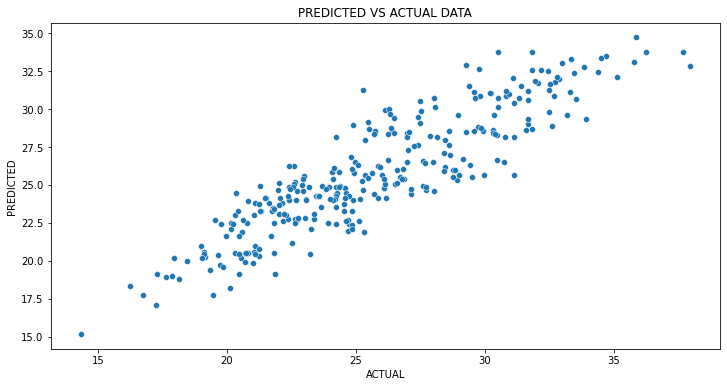

In [60]:
plt.figure(figsize=(12,6))
plt.title("PREDICTED VS ACTUAL DATA")
sns.scatterplot(data=OUTPUT, x="ACTUAL", y = "PREDICTED");